In [1]:
import numpy as np
import pandas as pd

from conf_eval import metrics, plot
import seaborn as sns

from sklearn.metrics import accuracy_score, roc_auc_score
from nonconformist_DL.icp import IcpClassifierDl

from nonconformist_DL.nc import NcFactory, ClassifierNcDl, MarginErrFunc

# Set the figure size to re-use so it fits the screen OK
fig_size = (14,7)

# Set a different style and context
plot.update_plot_settings(context='talk', font_scale=1.2)

In [2]:
df_train = pd.read_csv('/home/jovyan/my_code/uncertainty/data/hERG/1/hERG_train.csv')
df_test = pd.read_csv('/home/jovyan/my_code/uncertainty/data/hERG/1/hERG_test.csv')
df_val = pd.read_csv('/home/jovyan/my_code/uncertainty/data/hERG/1/hERG_val.csv')

y_test_smi = np.array(df_test['smiles'])
y_test_clf = np.array(df_test['hERG'])

y_calib_smi = np.array(df_val['smiles'])
y_calib_clf = np.array(df_val['hERG'])

In [3]:
import chemprop

arguments = [
    '--test_path', '/dev/null',
    '--preds_path', '/dev/null',
    '--checkpoint_dir', '/home/jovyan/my_code/uncertainty/checkpoints/hERG/hERG_1_model'
]

args = chemprop.args.PredictArgs().parse_args(arguments)
model_objects = chemprop.train.load_model(args=args)
smiles = [[s]for s in y_calib_smi]

preds = chemprop.train.make_predictions(
    args=args, 
    smiles=smiles, 
    model_objects=model_objects
    )

preds = np.array([[1-p[0], p[0]] for p in preds])

test_preds = chemprop.train.make_predictions(
    args=args, 
    smiles=[[s] for s in y_test_smi], 
    model_objects=model_objects
    )

test_preds = np.array([[1-p[0], p[0]] for p in test_preds])

Loading training args


/home/jovyan/miniconda3/envs/py39/lib/python3.9/site-packages/chemprop/utils.py:473: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vars(torch.load(path, map_location=lambda 

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight".
Loading pretrained parameter "readout.4.bias".
Setting molecule featurization parameters to default.
Loading data
Validating SMILES


/home/jovyan/miniconda3/envs/py39/lib/python3.9/site-packages/chemprop/utils.py:418: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(path, map_location=lamb

Test size = 988


100%|██████████| 1/1 [00:07<00:00,  7.05s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:08
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 988


100%|██████████| 1/1 [00:11<00:00, 11.31s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:13


In [4]:
# df_train = pd.read_csv('/home/jovyan/my_code/uncertainty/data/hERGDB/hERGDB_cls_train_data.csv')
# df_test = pd.read_csv('/home/jovyan/my_code/uncertainty/data/hERGDB/hERGDB_cls_week1_1201.csv')
# df_val = pd.read_csv('/home/jovyan/my_code/uncertainty/data/hERGDB/hERGDB_cls_valid_data.csv')

# y_train_clf = np.array(df_train['class'])
# y_test_clf = np.array(df_test['class'])
# y_calib_clf = np.array(df_val['class'])

In [5]:
MarginErrFunc().apply(prediction= np.array([[0.99],[0]]), y=np.array([1]))

array([0.995, 0.5  ])

In [6]:
icp = IcpClassifierDl(condition=lambda x: x[1]) 
icp.calibrate(y_true = np.array(y_calib_clf.copy()), y_pred = preds.copy())

In [ ]:
icp._get_stats(np.array([[0.99],[0]]).copy())

In [11]:
# Predict the test set, this can be done in two ways;
# i.e. 95% confidence - we get a matrix for the included classes
predictions = icp.predict(test_preds.copy(), significance=.05) 
np.random.seed(567)
pvalues = icp.predict(test_preds.copy()) # Or no significance - get the raw p-values

print("\nPredicted classes:")
print(predictions[:5])
print("\nP-values:")
print(pvalues[:5])

# print('confidence', icp.predict_conf(X_test_clf[:3]))# Predict with confidence intervals

y_pred-1 [[1.57427788e-03 9.98425722e-01]
 [9.99890572e-01 1.09428198e-04]
 [3.49388778e-01 6.50611222e-01]
 ...
 [2.86501408e-01 7.13498592e-01]
 [9.90769207e-01 9.23079252e-03]
 [8.60530138e-03 9.91394699e-01]]
y_pred-2 [[1.57427788e-03 9.98425722e-01]
 [9.99890572e-01 1.09428198e-04]
 [3.49388778e-01 6.50611222e-01]
 ...
 [2.86501408e-01 7.13498592e-01]
 [9.90769207e-01 9.23079252e-03]
 [8.60530138e-03 9.91394699e-01]]
before y_pred [[1.57427788e-03 9.98425722e-01]
 [9.99890572e-01 1.09428198e-04]
 [3.49388778e-01 6.50611222e-01]
 ...
 [2.86501408e-01 7.13498592e-01]
 [9.90769207e-01 9.23079252e-03]
 [8.60530138e-03 9.91394699e-01]] test_class [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [12]:
# print('primary model: acc',accuracy_score(y_test_clf, primary_model_preds), 'auc', roc_auc_score(y_test_clf, primary_model_preds))

In [13]:
predictions = icp.predict_conf(test_preds.copy())
cp_y_pred=  predictions[:, 0]
print('CP model: acc',accuracy_score(y_test_clf, cp_y_pred), 'auc', roc_auc_score(y_test_clf, cp_y_pred))

y_pred-1 [[1.57427788e-03 9.98425722e-01]
 [9.99890572e-01 1.09428198e-04]
 [3.49388778e-01 6.50611222e-01]
 ...
 [2.86501408e-01 7.13498592e-01]
 [9.90769207e-01 9.23079252e-03]
 [8.60530138e-03 9.91394699e-01]]
y_pred-2 [[1.57427788e-03 9.98425722e-01]
 [9.99890572e-01 1.09428198e-04]
 [3.49388778e-01 6.50611222e-01]
 ...
 [2.86501408e-01 7.13498592e-01]
 [9.90769207e-01 9.23079252e-03]
 [8.60530138e-03 9.91394699e-01]]
before y_pred [[1.57427788e-03 9.98425722e-01]
 [9.99890572e-01 1.09428198e-04]
 [3.49388778e-01 6.50611222e-01]
 ...
 [2.86501408e-01 7.13498592e-01]
 [9.90769207e-01 9.23079252e-03]
 [8.60530138e-03 9.91394699e-01]] test_class [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [14]:
after_y_test_clf = []
after_y_pred_clf = []
for i, j in zip(y_test_clf, icp.predict(test_preds.copy(),significance=.21)):
    if j[0]==j[1]:
        pass
    else:
        after_y_pred_clf.append(np.where(j==True)[0][0])
        after_y_test_clf.append(i)

print(f"CP model:\nnum: {len(after_y_test_clf)}",'auc', roc_auc_score(after_y_test_clf, after_y_pred_clf), 'acc',accuracy_score(after_y_test_clf, after_y_pred_clf))

y_pred-1 [[1.57427788e-03 9.98425722e-01]
 [9.99890572e-01 1.09428198e-04]
 [3.49388778e-01 6.50611222e-01]
 ...
 [2.86501408e-01 7.13498592e-01]
 [9.90769207e-01 9.23079252e-03]
 [8.60530138e-03 9.91394699e-01]]
y_pred-2 [[1.57427788e-03 9.98425722e-01]
 [9.99890572e-01 1.09428198e-04]
 [3.49388778e-01 6.50611222e-01]
 ...
 [2.86501408e-01 7.13498592e-01]
 [9.90769207e-01 9.23079252e-03]
 [8.60530138e-03 9.91394699e-01]]
before y_pred [[1.57427788e-03 9.98425722e-01]
 [9.99890572e-01 1.09428198e-04]
 [3.49388778e-01 6.50611222e-01]
 ...
 [2.86501408e-01 7.13498592e-01]
 [9.90769207e-01 9.23079252e-03]
 [8.60530138e-03 9.91394699e-01]] test_class [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [15]:
# test_error = pd.read_csv('/home/jovyan/my_code/uncertainty/output/1_hERG_test_pred.csv')

# pvalues = np.ones((len(test_error['hERG']),2))
# for i in range(len(test_error['hERG'])):
#     pvalues[i,0] = test_error['hERG'][i]
#     pvalues[i,1] = 1-test_error['hERG'][i]
# y_test_clf = np.array(test_y['hERG'])

# assert len(pvalues) == len(y_test_clf)

In [16]:
print(
    metrics.average_c(pvalues, 0.1),
    metrics.average_c(pvalues, 0.2),
    metrics.average_c(pvalues, 0.3),
    )

print(
    metrics.frac_single_label_preds(y_test_clf,pvalues, 0.1),
    metrics.frac_single_label_preds(y_test_clf,pvalues, 0.2),
    metrics.frac_single_label_preds(y_test_clf,pvalues, 0.3),
    )

0.7004048582995951 0.9878542510121457 1.1619433198380567
(0.7004048582995951, 0.5840080971659919, 0.11639676113360324) (0.9878542510121457, 0.7661943319838057, 0.2216599190283401) (0.8380566801619433, 0.6781376518218624, 0.15991902834008098)


Observed fuzziness: 0.145
Confusion matrix using significance ε=0.1



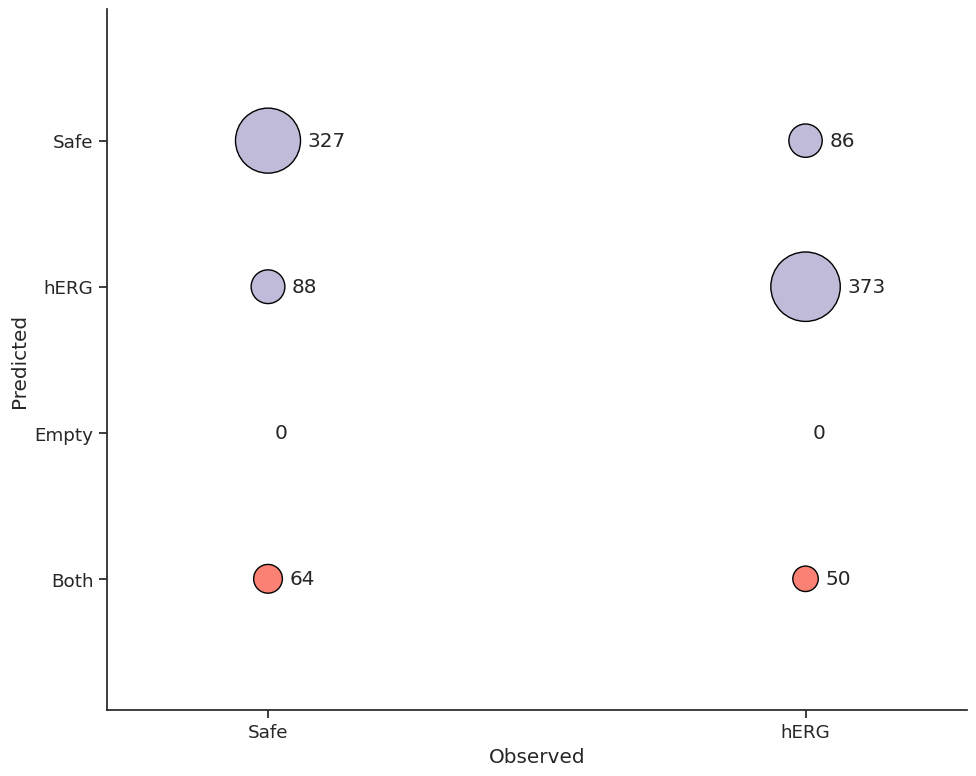

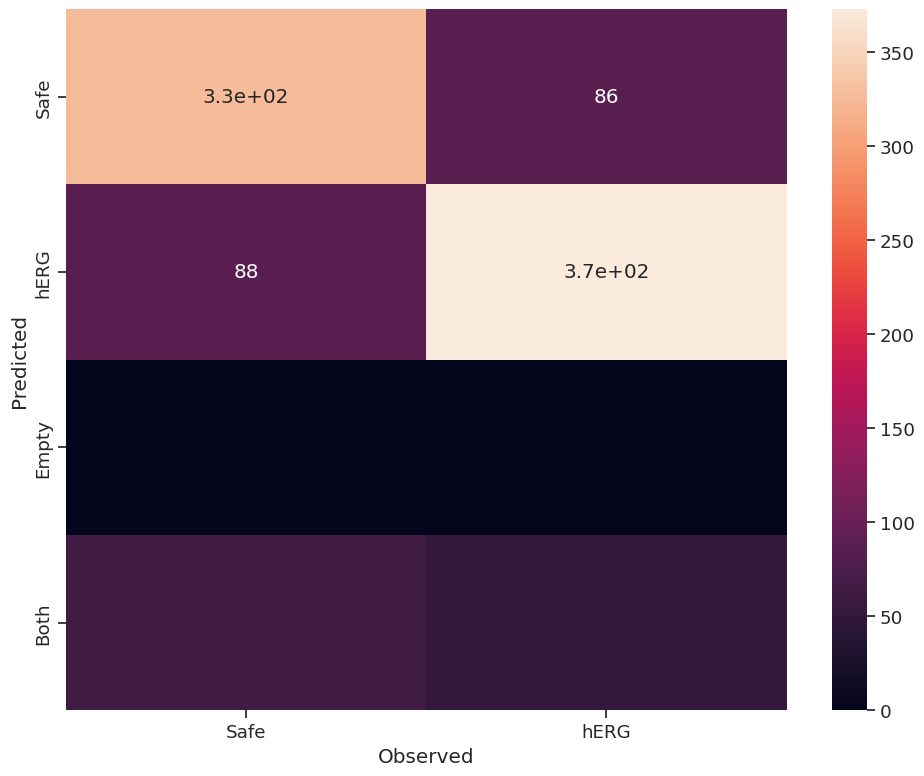

In [17]:
obs_fuzz = metrics.obs_fuzziness(y_test_clf,pvalues)
print("Observed fuzziness: %.3f" % obs_fuzz)

CM = metrics.confusion_matrix(y_test_clf, pvalues, sign=0.15, labels=['Safe','hERG'])
print('Confusion matrix using significance \u03B5=0.1\n')

# Plot the confusion matrix with bubbles - requries seaborn!
CM_plot = plot.plot_confusion_matrix_bubbles(CM,
                                                annotate=True) # If numbers should be printed next to bubbles

heatmap_fig = plot.plot_confusion_matrix_heatmap(CM)

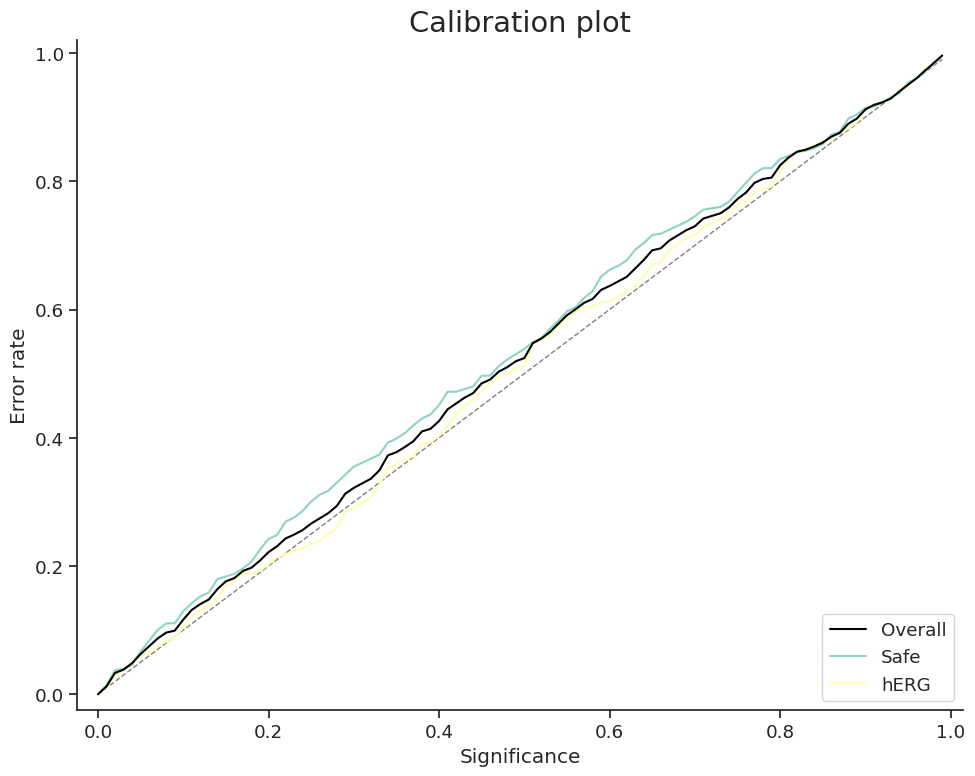

In [18]:
# Perhaps most important, the calibration plot:
calib_fig = plot.plot_calibration_clf(y_test_clf, 
                                            pvalues, 
                                            title='Calibration plot',
                                            labels=['Safe','hERG'],
                                            figsize=None)

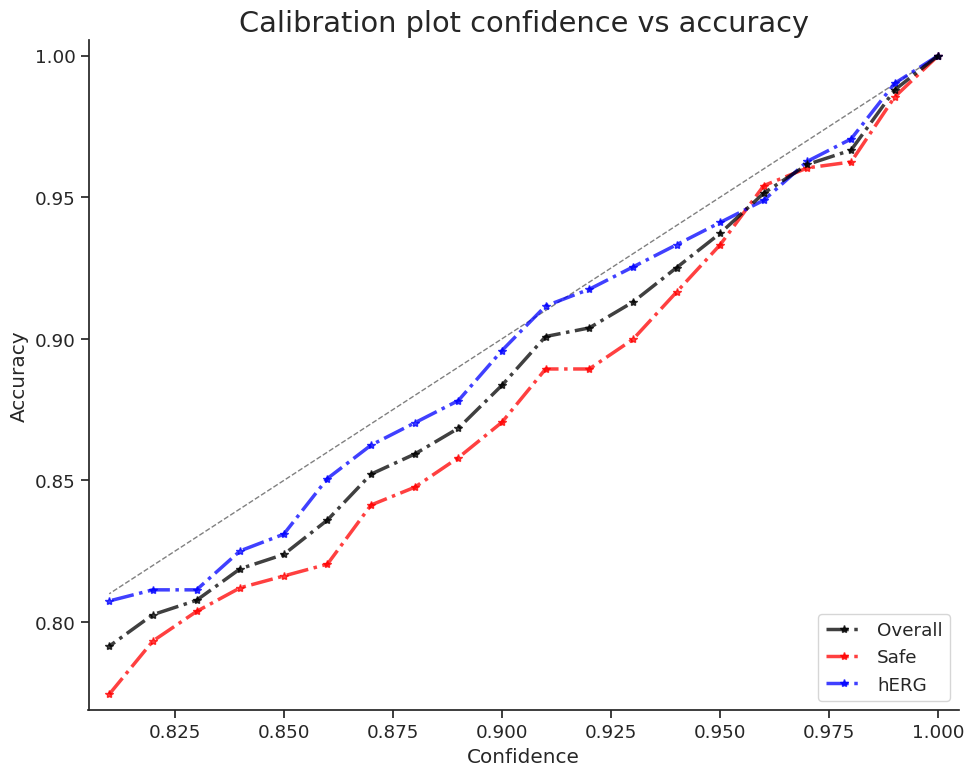

In [19]:
# Here we can customize the lines by passing matplotlib kw-arguments 
# These are passed on to the axes.plot(..) method
line_args = {'alpha': 0.75, 'marker':"*", 'linestyle': '-.', 'linewidth':2.5}

# Or if you prefer confidence vs accuracy:
conf_vs_acc_fig = plot.plot_calibration_clf(y_test_clf, 
                                            pvalues, 
                                            title='Calibration plot confidence vs accuracy',
                                            labels=['Safe','hERG'],
                                            sign_vals=np.arange(0.0,.2,0.01),
                                            cm = ['red','blue','green'],
                                            plot_all_labels=True, # If false - only plot 'overall accuracy'
                                            flip_x=True, # confidence instead of significance on x-axis
                                            flip_y=True, # accuracy instead of error rate on y-axis
                                            **line_args) # passed on to matplotlib 

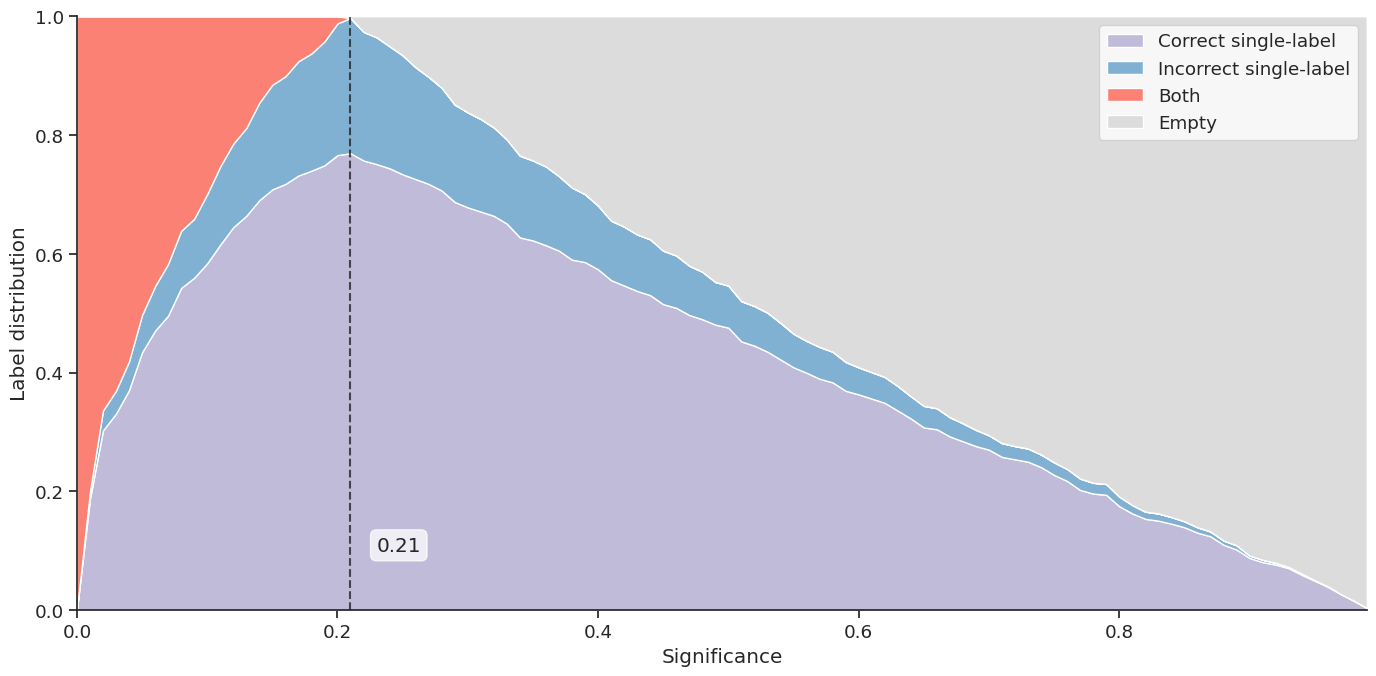

In [20]:
label_distr_fig = plot.plot_label_distribution(y_true=y_test_clf,
                                                   p_values=pvalues,
                                                   sign_vals=np.arange(0,1,0.01),
                                                   mark_best=True,
                                                   display_incorrect=True,
                                                   figsize = fig_size)

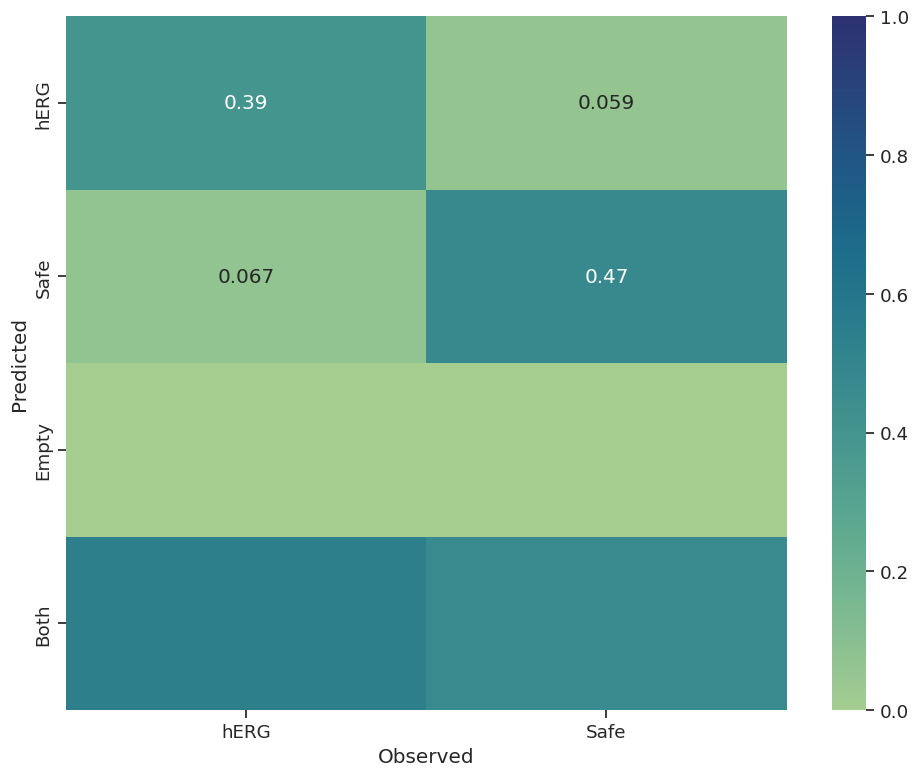

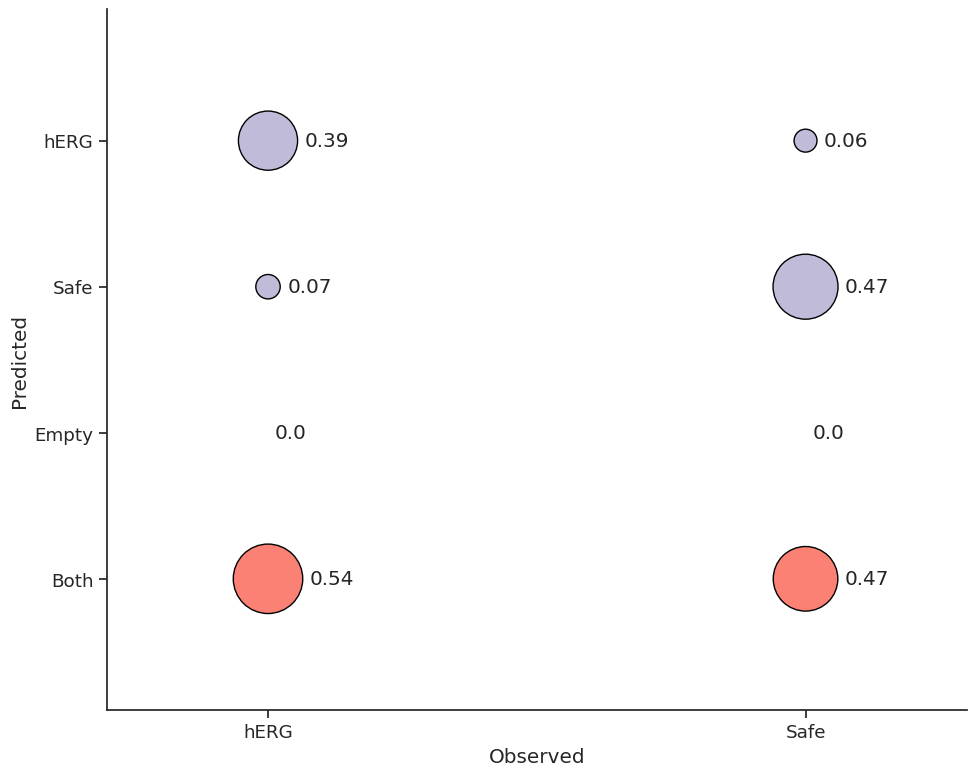

In [21]:
CM_norm = metrics.confusion_matrix(y_test_clf, 
                                   pvalues, 
                                   sign=0.05, 
                                   labels=['hERG','Safe'], 
                                   normalize_per_class=True)

heatmap_normalized_fig = plot.plot_confusion_matrix_heatmap(CM_norm,
                                                                cmap=sns.color_palette("crest", as_cmap=True),
                                                                vmin=0, vmax=1)

bubbles_normalized_plot = plot.plot_confusion_matrix_bubbles(CM_norm,
                                                                 annotate=True)

